In [26]:
import numpy as np
import numpy.random as rd
import math
import matplotlib.pyplot as plt
from scipy import misc

# Fonction de densité d'une loi GGA

In [27]:
# fonction de densité d'une loi GGA


def f(x, parametres):
    """

    :param x:
    :param parametres:
    :return:
    """
    poids, alpha, lambd, gamma, mu = parametres
    delta = (2*(alpha**lambd)*(1-alpha)**lambd)/(alpha**lambd+(1-alpha)**lambd)
    A = (delta**(1/lambd))/(gamma**(1/lambd)*math.gamma(1+1/lambd))
    B = (-(delta/gamma)*(abs(mu-x))**lambd)
    if x < mu:
        p = A*np.e**(B/(alpha**lambd))
    else:
        p = A*np.e**(B/((1-alpha)**lambd))
    return p


def f2(X,parametres):
    """
    fonction de densité de la loi GGA, avec x un array
    """
    n = len(X)
    Y = np.zeros(n)
    for i in range(n):
        Y[i] = f(X[i], parametres)
    return Y

# approche intuitive de l'algorithme de Metropolis-Hastings


def creation_points(n, parametres):
    """
    :param n: nombre de points
    :param f: fonction de densité pour un nombre
    :return: vecteurs de n points suivant la distribution
    """
    X = np.zeros(n)
    X[0] = rd.random()
    for i in range(n-1):
        x = rd.normal(X[i], 10)
        alph = f(x, parametres)/f(X[i], parametres)
        if alph >= 1:
            X[i+1] = x
        else:
            if rd.random() <= (1-alph):
                X[i+1] = X[i]
            else:
                X[i+1] = x
    return X


# pour sommer des densités


def f_tot(x, param):
    """
    :param f: support de la fonction de prob
    :param param: dictionnaire, avec les paramètres de chaque fonction et leur poids
    :return: f_tot, la fonction de densité totale
    """
    m = len(param)
    p = 0
    for i in range(m):
        p += param[i][0]*f(x, param[i])
    return p


def f2_tot(X, param):
    """
    fonction de densité de la loi totale, avec x un array
    """
    n = len(X)
    Y = np.zeros(n)
    for i in range(n):
        Y[i] = f_tot(X[i], param)
    return Y


def creation_points_tot(n, param, q):
    """
    :param n:nombre de points
    :param f_tot: fonction de distribution totale
    :param f: focntion de distribution de base
    :param param: tableau des paramètres des fonctions
    :param q: variance de la loi normale pour le choix de x autour de X[i]
    :return: une liste de points répartis selon les distributions avec leur poids
    """

    X = np.zeros(n)
    X[0] = 20
    for i in range(n-1):
        x = rd.normal(X[i], q)
        alph = f_tot(x, param)/f_tot(X[i], param)
        if alph >= 1:
            X[i+1] = x
        else:
            if rd.random() <= (1-alph):
                X[i+1] = X[i]
            else:
                X[i+1] = x
    return X

## Test

C:\Users\Matthieu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Matthieu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Matthieu\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


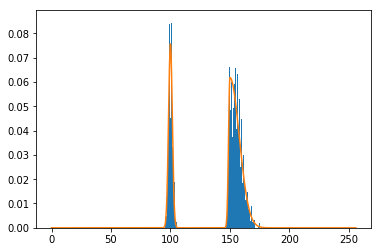

In [28]:
poids1 = 0.3
lambd1 = 2
alpha1 = 1/2
gamma1 = 5
mu1 = 100
param1 = [poids1, alpha1, lambd1, gamma1, mu1]

poids2 = 0.7
lambd2 = 2
alpha2 = 1/8
gamma2 = 5
mu2 = 150
param2 = [poids2, alpha2, lambd2, gamma2, mu2]

param = [param1, param2]

n = 10000
q= 50
    
X_ech = creation_points_tot(n, param, q)
count, bins, ignored = plt.hist(X_ech, 500, normed=True, range=(0, 256))

X = np.linspace(bins.min(), bins.max(), 1000)
Y = f2_tot(X, param)
plt.plot(X, Y)
plt.show()


# Algorithme EM

In [29]:
def init_EM(M, X, mu1, mu2):
    """
    initialise M lois GGA
    :param M: entier, nombre de classe
    :param X: échantillon
    :return: param, matrice de M lignes, et 5 colonnes: poids, lambda, gamma, mu
    """
    x_min = min(X)
    x_max = max(X)
    param = [[1/M, 1/2, rd.uniform(0.1, 100), rd.uniform(0.1, 100), mu1],
            [1/M, 1/2, rd.uniform(0.1, 100), rd.uniform(0.1, 100), mu2]]
    return param


### Etape E

In [30]:
def etape_E(X, M, param):
    """

    :param X: echantillon
    :param M: nombre de classe
    :param param: paramètres initiaux
    :return: une matrice de taille len(X)*M avec pi,j la proba que xi vienne de la distribution fj
    """
    P = np.zeros((len(X), M))
    for i in range(len(X)):
        s=0
        x = X[i]
        for j in range(M):
            P[i][j] = f(x, param[j])
            s+=P[i][j]
        for j in range(M):
            P[i][j]=P[i][j]/s
    return P

### Etape B

In [31]:
def etape_B(X, M, param, P):
    for i in range(len(P)):
        if P[i].all() != 0:
            a=np.argmax(P[i])
            P[i]=M*[0]
            P[i][a]=1
        else :
            Mu=[abs(param[i][4]-X[i]) for i in range(M)]
            Mui=np.argmin(Mu)
            P[i]=M*[0]
            P[i][Mui]=1      
    return P

### Etape M

In [32]:
def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(x):
        args[var] = x
        return func(*args)
    return misc.derivative(wraps, point[var], dx = 1e-6)

In [33]:
def g(x,p1,p2,p3,p4,p5):
    p=[p1,p2,p3,p4,p5]
    return f(x,p)

In [35]:
k=0.5

def etape_M(X,M,param,P):
    for i in range(M):
        print('i=',i)
        p1,p2,p3,p4,p5=param[i]
        for j in range(5):
            print('j=',j)
            s=0
            for l in range(len(X)):
                s+=partial_derivative(g,j+1, point=([X[l],p1,p2,p3,p4,p5]))
                if l<10:
                    print('dérivée=',partial_derivative(g,j+1, point=([X[l],p1,p2,p3,p4,p5])))
            param[i][j]=param[i][j]-k*s
    print('param= ',param)
    return param


# Boucle

C:\Users\Matthieu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Matthieu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Matthieu\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Matthieu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


[[0.5, 0.5, 86.09275926545543, 72.97216778492063, 150], [0.5, 0.5, 95.38186247383567, 38.71779351216393, 100]]
i= 0
j= 0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
j= 1
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
j= 2
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
j= 3
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
j= 4
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
i= 1
j= 0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
j= 1
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0
dérivée= 0.0

C:\Users\Matthieu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Matthieu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


[[0.5, 215.11245288656784, 86.0948199938501, 72.96938025968088, 44.5215302262492], [0.5, 158.81559818968327, 95.17907016311362, 38.8702738389269, 23.02829535775082]]
i= 0
j= 0
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
j= 1
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
j= 2
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
j= 3
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
j= 4
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
i= 1
j= 0
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
dérivée= nan
j= 1
dérivée= 

KeyboardInterrupt: 

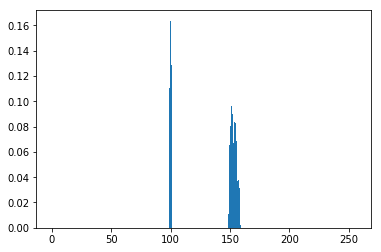

In [36]:
poids1 = 0.3
lambd1 = 10
alpha1 = 1/2
gamma1 = 5
mu1 = 100
param1 = [poids1, alpha1, lambd1, gamma1, mu1]

poids2 = 0.7
lambd2 = 10
alpha2 = 1/8
gamma2 = 5
mu2 = 150
param2 = [poids2, alpha2, lambd2, gamma2, mu2]

param0 = [param1, param2]

n=10000
q=50

X_ech = creation_points_tot(n, param0, q)
count, bins, ignored = plt.hist(X_ech, 500, normed=True, range=(0, 256))

M = 2

param=init_EM(M, X_ech, 150, 100)

for i in range(5):
    P0=etape_E(X_ech,M,param)
    P=etape_B(X_ech, M, param, P0)
    print(param)
    param=etape_M(X_ech,M,param,P)

X = np.linspace(bins.min(), bins.max(), 1000)
Y = f2_tot(X, param)
plt.plot(X, Y)
plt.show()



In [17]:
n = 100000
q= 50
    
X_ech = creation_points_tot(n, f_tot, f, param0, q)
count, bins, ignored = plt.hist(X_ech, 500, normed=True, range=(0, 256))

X = np.linspace(bins.min(), bins.max(), 1000)
Y = f2_tot(X, f, param)
plt.plot(X, Y)
plt.show()


TypeError: creation_points_tot() takes 3 positional arguments but 5 were given

In [19]:
def h(x,y):
    return x**2-y**2

partial_derivative(h, var=1, point=[1,3])

-6.000000000838668

In [40]:
for i in range(10000):
    print(f(X_ech[i],[0.5, 215.11245288656784, 86.0948199938501, 72.96938025968088, 44.5215302262492]))
    np.seterr('raise')

(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)

(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)

(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)

(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)

(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)

(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)